In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from math import sqrt
import datetime

# Random Forest

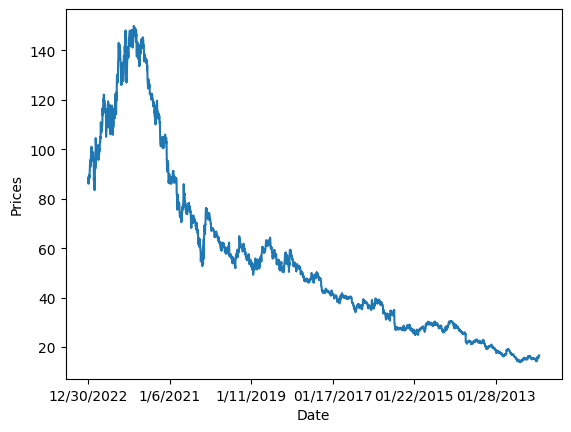

In [2]:
# Load and visualize dataset
dataset = pd.read_csv('GOOGL Historical Data.csv')
dataset.set_index("Date", inplace=True)
dataset['Price'].plot()
plt.ylabel("Prices")
plt.show()

In [3]:
# Clean data and separate features and target variable
dataset.dropna(inplace=True)
features = dataset.iloc[:, 0:4].values
target = dataset.iloc[:, 2].values

In [4]:
# Standardize features
scaler = StandardScaler()
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=0)
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [5]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features_train, target_train)
predictions = rf_model.predict(features_test)

In [6]:
# Define grid for hyperparameter tuning
param_grid = {
    'n_estimators': [20, 50, 100, 500, 1000],  
    'max_depth': np.arange(1, 15, 1),  
    'min_samples_split': [2, 10, 9], 
    'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
    'bootstrap': [True, False], 
    'random_state': [1, 2, 30, 42]
}

# Perform hyperparameter tuning
tuner = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=3, n_jobs=-1, verbose=2, n_iter=200)
tuner.fit(features_train, target_train)
best_params = tuner.best_params_
print(best_params)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 2, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 13, 'bootstrap': True}


In [7]:
# Train model with best parameters
optimal_model = RandomForestRegressor(n_estimators=100, random_state=2, min_samples_split=2, min_samples_leaf=1, max_depth=13, bootstrap=True)
optimal_model.fit(features_train, target_train)
optimal_predictions = optimal_model.predict(features_test)

In [8]:
# Calculate error metrics
mae = round(mean_absolute_error(target_test, optimal_predictions), 4)
mse = round(mean_squared_error(target_test, optimal_predictions), 4)
rmse = round(np.sqrt(mse), 4)
r2 = round(r2_score(target_test, optimal_predictions), 4)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("(R^2) Score:", r2)

# Calculate accuracy
mape = 100 * (abs(optimal_predictions - target_test) / target_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 0.0564
Mean Squared Error: 0.016
Root Mean Squared Error: 0.1265
(R^2) Score: 1.0
Accuracy: 99.9 %.


In [9]:
# Make predictions for the next 6 months
predictions_df = pd.DataFrame({"Predictions": optimal_predictions}, index=pd.date_range(start=dataset.index[-1], periods=len(optimal_predictions), freq="D"))
six_month_predictions = pd.DataFrame(predictions_df[:124])
six_month_predictions.to_csv("GOOGL Prediction RF.csv")

Buy price and date
          Predictions
Date                 
6/8/2023      14.2032
Sell price and date
            Predictions
Date                   
03/16/2023     148.0718


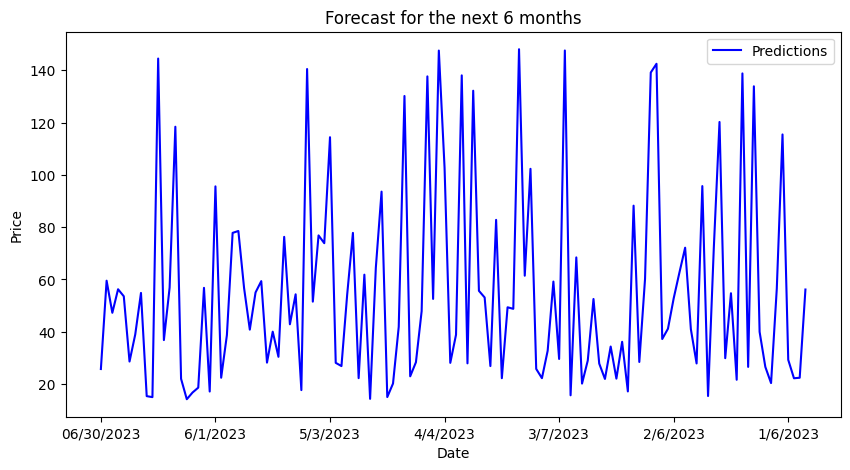

In [10]:
# Find buy and sell price and date
prediction_data = pd.read_csv("GOOGL Prediction RF.csv")
prediction_data.set_index("Date", inplace=True)
buy_price = min(prediction_data["Predictions"])
sell_price = max(prediction_data["Predictions"])
buy_date = prediction_data.loc[prediction_data["Predictions"] == buy_price]
sell_date = prediction_data.loc[prediction_data["Predictions"] == sell_price]
print("Buy price and date")
print(buy_date)
print("Sell price and date")
print(sell_date)

# Plot prediction
prediction_data["Predictions"].plot(figsize=(10, 5), title="Forecast for the next 6 months", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

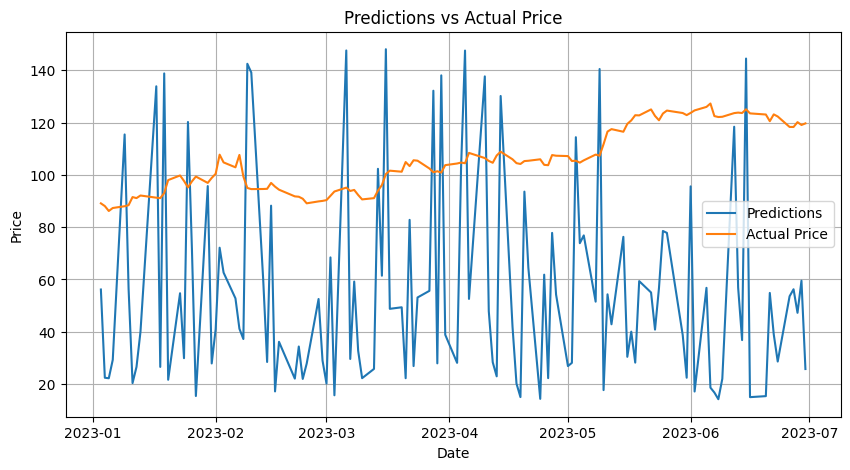

In [11]:
# Compare predictions to actual data
actual_data = pd.read_csv('GOOGL Historical Data 2023.csv')
predicted_data = pd.read_csv("GOOGL Prediction RF.csv")
actual_data['Date'] = pd.to_datetime(actual_data['Date'])
predicted_data['Date'] = pd.to_datetime(predicted_data['Date'])
merged_data = pd.merge(actual_data, predicted_data, on='Date')

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(merged_data['Date'], merged_data['Predictions'], label='Predictions')
plt.plot(merged_data['Date'], merged_data['Price'], label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predictions vs Actual Price')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Calculate and print metrics
mae = mean_absolute_error(merged_data['Price'], merged_data['Predictions'])
mse = mean_squared_error(merged_data['Price'], merged_data['Predictions'])
rmse = np.sqrt(mse)  
r2 = r2_score(merged_data['Price'], merged_data['Predictions'])
print("Mean Absolute Error:", round(mae, 4))
print("Mean Squared Error:", round(mse, 4))
print("Root Mean Squared Error:", round(rmse, 4))
print("(R^2) Score:", round(r2, 4))

# Calculate and print MAPE and Accuracy
errors = abs(merged_data['Predictions'] - merged_data['Price'])
mape = 100 * (errors / merged_data['Price'])
accuracy = 100 - np.mean(mape)
print('Mean Absolute Percentage Error (MAPE):', round(mape.mean(), 2), '%')
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 58.7799
Mean Squared Error: 4089.9827
Root Mean Squared Error: 63.953
(R^2) Score: -27.9637
Mean Absolute Percentage Error (MAPE): 55.48 %
Accuracy: 44.52 %.


# Support Vector Regression

In [13]:
# Load the company stock data
df = pd.read_csv('GOOGL Historical Data.csv')
df = df.sort_values('Date')

# Calculate the number of days from the start
df['Date'] = pd.to_datetime(df['Date'])
start_date = df['Date'].min()
df['Date'] = (df['Date'] - start_date).dt.days

# Prepare the features (Date) and target (Price)
X = df['Date'].values.reshape(-1, 1)
y = df['Price'].values

In [14]:
# Standardize the features and target
scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y.reshape(-1, 1))
X = scaler_X.transform(X)
y = scaler_y.transform(y.reshape(-1, 1)).ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Create and train the Support Vector Machine (Regressor)
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(X_train, y_train)

# Test the model
svr_rbf_confidence = svr_rbf.score(X_test, y_test)
print("svr_rbf confidence: ", svr_rbf_confidence)

svr_rbf confidence:  0.9219284327923574


In [16]:
# Predict the future stock prices (Next 6 months, 30 days/month)
x_forecast = np.array(list(range(max(df['Date']), max(df['Date']) + 124))).reshape(-1, 1)
x_forecast_scaled = scaler_X.transform(x_forecast)
forecast_result_scaled = svr_rbf.predict(x_forecast_scaled)
forecast_result = scaler_y.inverse_transform(forecast_result_scaled)

In [17]:
# Convert the day numbers back to dates
forecast_dates = pd.date_range(start=start_date + pd.DateOffset(days=max(df['Date'])), periods=124).strftime('%m/%d/%Y')

# Save predictions to CSV file
pred_df = pd.DataFrame({
    "Date": forecast_dates,
    "Predictions": forecast_result
})
pred_df.to_csv("GOOGL Prediction SVM.csv", index=False)

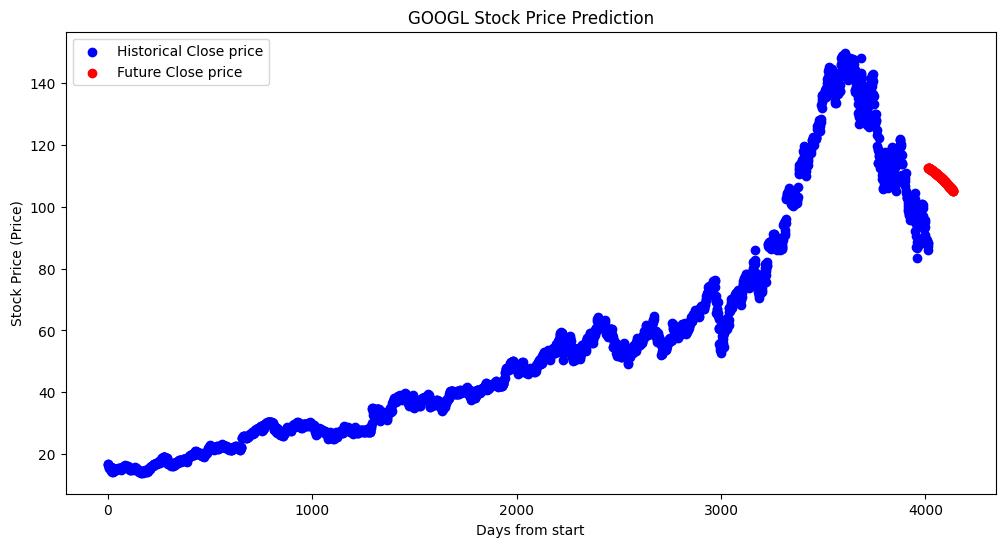

In [18]:
# Plot the prediction as scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df['Date'].values, df['Price'].values, color='blue', label='Historical Close price')
plt.scatter(x_forecast, forecast_result, color='red', label='Future Close price')
plt.title('GOOGL Stock Price Prediction')
plt.xlabel('Days from start')
plt.ylabel('Stock Price (Price)')
plt.legend()
plt.show()

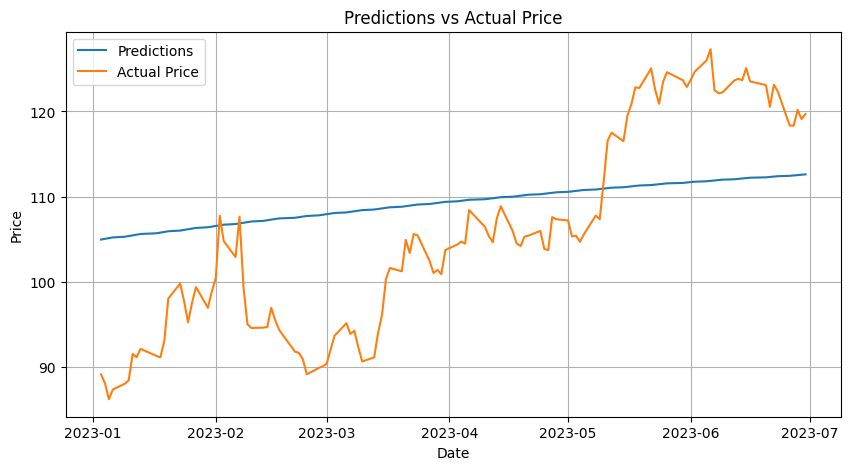

In [20]:
# Compare predictions to actual data
actual_data = pd.read_csv('GOOGL Historical Data 2023.csv')
predicted_data = pd.read_csv("GOOGL Prediction SVM.csv")
actual_data['Date'] = pd.to_datetime(actual_data['Date'])
predicted_data['Date'] = pd.to_datetime(predicted_data['Date'])
merged_data = pd.merge(actual_data, predicted_data, on='Date')

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(merged_data['Date'], merged_data['Predictions'], label='Predictions')
plt.plot(merged_data['Date'], merged_data['Price'], label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predictions vs Actual Price')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Calculate and print metrics
mae = mean_absolute_error(merged_data['Price'], merged_data['Predictions'])
mse = mean_squared_error(merged_data['Price'], merged_data['Predictions'])
rmse = np.sqrt(mse)  
r2 = r2_score(merged_data['Price'], merged_data['Predictions'])
print("Mean Absolute Error:", round(mae, 4))
print("Mean Squared Error:", round(mse, 4))
print("Root Mean Squared Error:", round(rmse, 4))
print("(R^2) Score:", round(r2, 4))

Mean Absolute Error: 9.5094
Mean Squared Error: 113.0675
Root Mean Squared Error: 10.6333
(R^2) Score: 0.1993
